In [1]:
import cometcurve as cc
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from theano import tensor as tt
import exoplanet as xo

In [2]:

cm = cc.CometModel(comet="2019 Y4", start="2020-02-01", stop="2020-07-01")
cm = cc.CometModel(comet="1962 C1", start="1962-01-01", stop="1962-12-01")
# cm = cc.CometModel(cobs_id="C/2006 P1", start="2006-01-01", stop="2006-12-31",
#               horizons_id="C/2006 P1")
cm.obs = cc.read_cobs(comet="1962 C1", years=1962)

cm2 = cc.CometModel(comet="1962 C1", start="1962-01-01", stop="1962-12-01")
# cm = cc.CometModel(cobs_id="C/2006 P1", start="2006-01-01", stop="2006-12-31",
#               horizons_id="C/2006 P1")
cm2.obs = cc.read_cobs(comet="1962 C1", years=1962)

Obtaining ephemeris for 2019%20Y4 from JPL/Horizons...
Obtaining ephemeris for 1962%20C1 from JPL/Horizons...
Obtaining ephemeris for 1962%20C1 from JPL/Horizons...


/Users/tsbarcl2/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


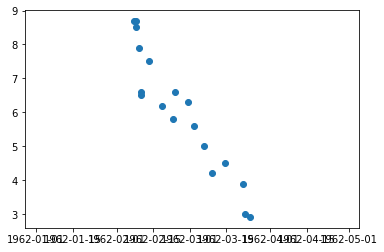

In [6]:
cm.obs.data = cm.obs.data.loc[cm.obs.data.time < '1962-04']


idx = np.argsort(cm.obs.data.date)
plt.scatter(cm.obs.data.time, cm.obs.data.magnitude)
# # # cc.read_cobs(comet="2012 S1", years=('2011','2012','2013')).data



In [7]:
cm.plot_times = np.arange(cm.ephem.date.values[0],
                      cm.ephem.date.values[-1] + 1_000_000_000_000_000,
                      np.timedelta64(12, 'h'))

In [8]:
def create_pymc_model(cm, min_observations=0):
    """Returns a PyMC3 model."""
    dfobs = cm.obs.data[cm.obs.data.observations > min_observations]
    mask = np.ones_like(dfobs, dtype=bool)

    with pm.Model() as model:
        delta = cm.earth_distance_func(dfobs.time.values)
        npts = np.shape(dfobs.time.values)[0]
        r = cm.sun_distance_func(dfobs.time.values)
        # n = pm.Normal('n', mu=3.9, sigma=1.0)  # activity parameter
        n = pm.Gamma('n', mu=3.9, sigma=1.0)  # activity parameter
        # h = pm.Normal('h', mu=5.6, sigma=2.6)  # absolute magnitude
        h = pm.Gamma('h', mu=5.6, sigma=2.6)

        model_mag = comet_magnitude_power_law(h=h, n=n, delta=delta, r=r)


#         beta = 0.47 + pm.HalfNormal('beta', sigma=0.02)
#         obsmag = pm.Cauchy('obsmag', alpha=model_mag,
#                            beta=beta, observed=dfobs.magnitude)
        
        logw0 = pm.Normal("logw0", mu=-2, sd=1)
        logSw4 = pm.Normal("logSw4", mu=0, sd=10)
        logs2 = pm.Normal("logs2", mu=2 * np.log(0.5), sd=5)
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        tval_us = cm.obs.data.time.values.astype('float64') / 1.E9 / 24/60/60
        idx = np.argsort(tval_us)
        gp = xo.gp.GP(kernel, tval_us[idx],
                      tt.exp(logs2) + tt.zeros(npts))
        pm.DensityDist("obsmag", gp.log_likelihood, observed=dfobs.magnitude.values[idx] - model_mag[idx])
        pm.Deterministic("gp_pred", gp.predict())
        
        delta_plot = cm.earth_distance_func(cm.plot_times)
        r_plot = cm.sun_distance_func(cm.plot_times)
        model_mag_plot = comet_magnitude_power_law(h=h, n=n, delta=delta_plot, r=r_plot)
        pm.Deterministic('model_mag', model_mag_plot)
        tvalp = np.sort(cm.plot_times.astype('float64') / 1.E9 / 24/60/60)
        pm.Deterministic("gp_pred_plot", gp.predict(tvalp))
        
        pm.Deterministic('peak_mag', tt.min(model_mag_plot))

    return model


def comet_magnitude_power_law(h=10., n=4., delta=1., r=1.):
    """The conventional power-law formula to predict a comet's brightness.

    Parameters
    ----------
    h : float
        Absolute magnitude.
    n : float
        Activity parameter.
    delta : float
        Comet's geocentric distance in AU.
    r : float
        Comet's heliocentric distance in AU.
    """
    return h + 5*np.log10(delta) + 2.5*n*np.log10(r)



In [9]:
model = create_pymc_model(cm)

model.check_test_point()



n_log__     0.44
h_log__    -0.17
logw0      -0.92
logSw4     -3.22
logs2      -2.53
obsmag    -39.68
Name: Log-probability of test_point, dtype: float64

In [10]:
with model:
    map_soln = xo.optimize()
    
    trace = pm.sample(draws=2000, start=map_soln, step=xo.get_dense_nuts_step(target_accept=0.9))



optimizing logp for variables: [logs2, logSw4, logw0, h, n]
26it [00:01, 24.89it/s, logp=-2.275983e+01] 
message: Optimization terminated successfully.
logp: -46.08114499182873 -> -22.759828882819278
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logs2, logSw4, logw0, h, n]
Sampling 4 chains, 38 divergences: 100%|██████████| 10000/10000 [00:20<00:00, 493.58draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8339022683673676, but should be close to 0.9. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7726366476171121, but should be close to 0.9. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparam

In [11]:
pm.summary(trace, var_names=['logSw4', 'logw0', 'h', 'n', 'logs2'])

# 	mean	sd	hpd_3%	hpd_97%	mcse_mean	mcse_sd	ess_mean	ess_sd	ess_bulk	ess_tail	r_hat
# logSw4	-9.387	1.882	-12.944	-5.981	0.031	0.022	3582.0	3582.0	3670.0	3870.0	1.0
# logw0	-3.158	0.749	-4.558	-1.724	0.015	0.010	2615.0	2615.0	2615.0	3410.0	1.0
# h	6.057	0.818	4.385	7.573	0.018	0.013	2056.0	2056.0	2952.0	1693.0	1.0
# n	3.649	0.462	2.785	4.570	0.008	0.005	3732.0	3732.0	3777.0	3142.0	1.0
# logs2	-1.394	0.176	-1.726	-1.073	0.003	0.002	4785.0	4785.0	4790.0	4725.0	1.0

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
logSw4,-7.572,6.942,-19.890,2.463,0.297,0.210,547.0,547.0,516.0,1379.0,1.01
logw0,-1.164,1.213,-3.254,0.880,0.044,0.031,768.0,768.0,772.0,2122.0,1.01
h,6.578,0.398,6.048,7.131,0.016,0.012,585.0,585.0,1698.0,1074.0,1.00
n,3.771,0.444,2.874,4.574,0.011,0.007,1751.0,1751.0,1730.0,1313.0,1.00
logs2,-1.511,1.160,-3.962,-0.004,0.061,0.045,364.0,332.0,507.0,501.0,1.01


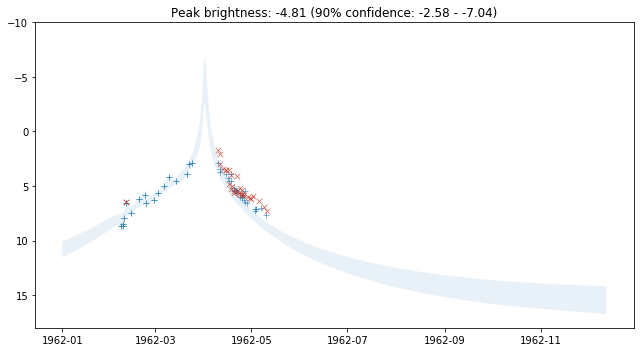

In [14]:
# pcts = np.percentile(trace['model_mag'], axis=0, q=[5, 50, 95])
pcts = np.percentile((trace['model_mag'] + trace['gp_pred_plot']), axis=0, q=[5, 50, 95])
fig = plt.figure(figsize=[9,5])
# for idx in range(0, len(trace.get_values('n')), int(len(trace.get_values('n'))/400)):
#     plt.plot(cm.plot_times, (trace['model_mag'] + trace['gp_pred_plot'])[idx], alpha=0.02, color='k')



plt.fill_between(cm.plot_times, pcts[0], pcts[2], alpha=0.1)

plt.scatter(cm.obs.data[cm.obs.data.visual].time,
           cm.obs.data[cm.obs.data.visual].magnitude,
           marker='+', lw=0.7, s=40, label="Visual observations",
           c='#2980b9', alpha=0.8, zorder=50)
plt.scatter(cm.obs.data[~cm.obs.data.visual].time,
           cm.obs.data[~cm.obs.data.visual].magnitude,
           marker='x', lw=0.7, s=30, label="CCD observations",
           c='#c0392b', alpha=0.8, zorder=50)


plt.scatter(cm2.obs.data[cm2.obs.data.visual].time,
           cm2.obs.data[cm2.obs.data.visual].magnitude,
           marker='+', lw=0.7, s=40, label="Visual observations",
           c='#2980b9', alpha=0.8, zorder=50)
plt.scatter(cm2.obs.data[~cm2.obs.data.visual].time,
           cm2.obs.data[~cm2.obs.data.visual].magnitude,
           marker='x', lw=0.7, s=30, label="CCD observations",
           c='#c0392b', alpha=0.8, zorder=50)

plt.ylim([int(np.max(pcts[1])+3), int(np.min(pcts[1]-6))])
peak = np.percentile(trace['peak_mag'], [5, 50, 95])
plt.title(f'Peak brightness: {peak[1]:.2f} (90% confidence: {peak[2]:.2f} - {peak[0]:.2f})')

fig.tight_layout()

In [69]:
a = np.percentile((trace['model_mag']), axis=0, q=[5, 50, 95])
b = np.percentile((trace['gp_pred_plot']), axis=0, q=[5, 50, 95])

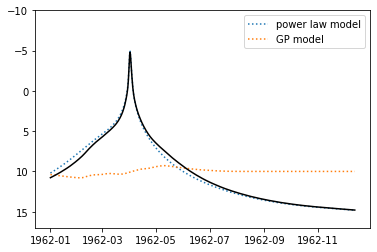

In [70]:
plt.ylim([int(np.max(pcts[1])+3), int(np.min(pcts[1]-6))])
plt.plot(cm.plot_times, a[1], ':', label='power law model')
plt.plot(cm.plot_times, b[1]+10, ':', label='GP model')
plt.plot(cm.plot_times, pcts[1], color='k')
plt.legend()